### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

2.1.0+cu118


In [ ]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

### Let's load the Flowers102 dataset


In [ ]:
data_path = './Flowers'
batch_size = 256

my_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224), # 448, 200 -> 224, 100
    torchvision.transforms.CenterCrop((224, 224)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    )

train_dataset = torchvision.datasets.Flowers102(data_path, 'train', transform= my_transform, download=True)
test_dataset = torchvision.datasets.Flowers102(data_path, 'test', transform= my_transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 344862509/344862509 [00:13<00:00, 24830636.96it/s]


Extracting Flowers/flowers-102/102flowers.tgz to Flowers/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1799607.36it/s]


100%|██████████| 14989/14989 [00:00<00:00, 15207649.41it/s]


### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current Device : {}'.format(device))

Current Device : cuda


### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
# sample = test_dataset[1]
print(sample[0].shape)
print(sample[1])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([256, 3, 224, 224])
tensor([ 72,  85,   1,  53,  79,  53,  19,  91,  91,  20,   7,  72,  84,  41,
         24,  34,  22,  38,  25,  74,  48,  40,  32,  76,  56,  91,  80,  51,
          6,  49,   0,  28,  58,  46,   1,  23,  51,  59,  10,  11,  37,  36,
         54,  69,  16,  87,  28,  10,  90,  89,  85,  71,   3,  17,  75,  91,
         40,  49,  22,  33,  29,  24,  20,  79,  41,   0,  27,  51,  72, 100,
         85,  39,  52,  14,  77,   3,  87,  22,  61,  98,  99,  22,  58,  71,
         66,  54,  43,  42,  53,  93,  49,  81,  53,  92,  60,  66,  46,  15,
         29,  74,  72,  35,  84,  87,  67,  94,  24,  28,  80,  60,  91,   5,
        100,  84,   9,   3,  61,  78,  87,  10, 100,  22,  83,   1,   8,  82,
         68,  94,  80,  74,  46,   6,  44,   4,  61,  47,  24,  26,  43,   4,
         13,  27,  94,  23,  89,  27,   8,  52,  53,   1,  79, 100,  80,  19,
         96,  15,  38,  95,  17,  92,  80,  35,  17,  83,  26,  45,  32,  86,
         64,  69,  69,  72,  21, 

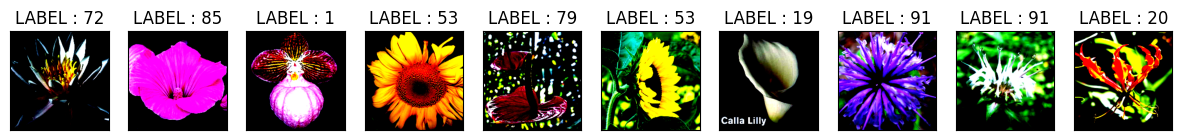

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(15, 4))
for plot_idx in range(10):
    ax[plot_idx].imshow(sample[0][plot_idx].permute(1, 2, 0))
    ax[plot_idx].set_title('LABEL : {}'.format(sample[1][plot_idx]))
    ax[plot_idx].set_xticks([])
    ax[plot_idx].set_yticks([])
plt.show()

### Define the ResNet Based Model

In [ ]:
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
print(resnet.layer)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [ ]:
class ResNets(nn.Module):
    def __init__(self, dim_output=102):
        super(ResNets, self).__init__()
        self.resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

        for p in self.resnet.parameters():
            p.requires_grad = False

        for p in list(self.resnet.layer4.parameters()):
            p.requires_grad = True

        self.resnet.fc = nn.Linear(2048, dim_output)

    def forward(self, img):
        return self.resnet(img)



In [ ]:
pretrained = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
for n, c in pretrained.named_children():
    print(n)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
class NewModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        self.pretrained = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        self.children_list = []
        for n,c in self.pretrained.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)

    def forward(self,x):
        x = self.net(x)
        return x

new_model = NewModel('layer4')
new_model(torch.rand(1, 3, 224, 224)).shape


torch.Size([1, 512, 7, 7])

### Define the Model

In [ ]:
model = ResNets()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

print(model)

ResNets(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    img = sample[0].float().to(device)
    label = sample[1].long().to(device)

    pred = model(img)

    num_correct = sum(torch.argmax(pred, dim=1) == label)

    pred_loss = criterion(pred, label)

    # Try to add the regularization loss!

    pred_loss.backward()

    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        img = sample[0].float().to(device)
        label = sample[1].long().to(device)

        pred = model(img)
        pred_loss = criterion(pred, label)

        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return pred_loss.item(), num_correct.item()

### Run Training

In [ ]:
max_epoch = 100
tmp_path = './checkpoint.pth'

for epoch in tqdm(range(max_epoch)):
    ###Train Phase

    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    torch.save(model.state_dict(), 'recent.pth')

    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)


    print('[epoch {}] Loss train: {:.02f} test:{:.02f} / Accu train: {:.02f} test:{:.02f}'.format(epoch+1, train_loss, test_loss, train_accu, test_accu))

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[epoch 1] Loss train: 4.61 test:4.59 / Accu train: 0.01 test:0.02
[epoch 2] Loss train: 4.43 test:4.51 / Accu train: 0.23 test:0.06
[epoch 3] Loss train: 4.22 test:4.37 / Accu train: 0.55 test:0.17
[epoch 4] Loss train: 3.98 test:4.18 / Accu train: 0.78 test:0.30
[epoch 5] Loss train: 3.69 test:3.95 / Accu train: 0.90 test:0.39
[epoch 6] Loss train: 3.37 test:3.65 / Accu train: 0.95 test:0.46
[epoch 7] Loss train: 3.03 test:3.32 / Accu train: 0.97 test:0.50
[epoch 8] Loss train: 2.68 test:3.00 / Accu train: 0.98 test:0.56
[epoch 9] Loss train: 2.30 test:2.70 / Accu train: 0.98 test:0.60
[epoch 10] Loss train: 1.96 test:2.43 / Accu train: 0.99 test:0.64
[epoch 11] Loss train: 1.63 test:2.18 / Accu train: 0.99 test:0.68
[epoch 12] Loss train: 1.32 test:1.95 / Accu train: 0.99 test:0.72


KeyboardInterrupt: ignored